In [1]:
import os
import glob
from collections import Counter
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
import numpy as np
import cartopy.crs as ccrs
import cmocean

from unseen import fileio

In [2]:
# Parameters
dpi = 300

In [11]:
ds_rx1day = fileio.open_dataset(
    '/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-20220405_daily_space-chunked.zarr/',
    metadata_file='/home/599/dbi599/unseen/config/dataset_agcd_daily.yml',
    variables=['pr'],
    point_selection=[-33.138378457908466, 136.41864477348216],
    time_freq='A-DEC',
    time_agg='max',
    input_freq='D',
    units={'pr': 'mm day-1'},
    time_agg_dates=True
)

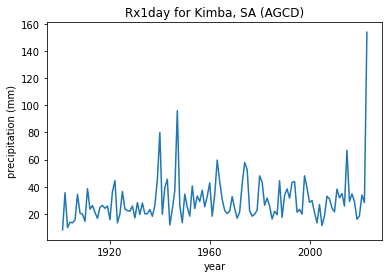

In [14]:
ds_rx1day['pr'].plot()
plt.title('Rx1day for Kimba, SA (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.show()

In [15]:
years = ds_rx1day['time'].dt.year.values
df_rx1day = pd.DataFrame(index=years)
df_rx1day['pr'] = ds_rx1day['pr'].values
df_rx1day['event_time'] = ds_rx1day['event_time'].values

In [17]:
ranked_events = df_rx1day.sort_values(['pr'], ascending=False)
ranked_events.head(n=10)

,pr,event_time
2022,153.939453,2022-01-22
1946,96.037109,1946-02-18
1939,79.930664,1939-11-03
2014,66.898438,2014-02-15
1962,59.588867,1962-12-29
1973,57.899414,1973-02-06
1974,52.557617,1974-01-29
1997,48.044922,1997-02-06
1979,47.994141,1979-05-25
1942,45.509766,1942-04-26


In [18]:
rx1day_max = df_rx1day['pr'].values.max()
print(rx1day_max)

153.93945


In [19]:
event_months = [int(date[5:7]) for date in ds_rx1day['event_time'].values]
event_years = [int(date[0:4]) for date in ds_rx1day['event_time'].values]

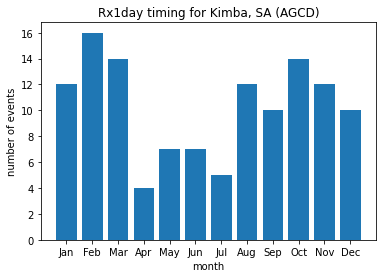

In [20]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title('Rx1day timing for Kimba, SA (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.show()

In [26]:
def gev_analysis(ds, event):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[10, 8])
    gev_xvals = np.arange(0, 160)
    ds.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlim(0, 160)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title('Rx1day for Kimba, SA (AGCD)')
    plt.show()
    
    event_probability = gev.sf(event, gev_shape, loc=gev_loc, scale=gev_scale)
    event_return_period = 1. / event_probability
    event_percentile = (1 - event_probability) * 100
    print(f'{event_return_period:.0f} year return period\n')
    print(f'{event_percentile:.2f}% percentile')

Shape parameter: -0.17
Location parameter: 22.57
Scale parameter: 9.11


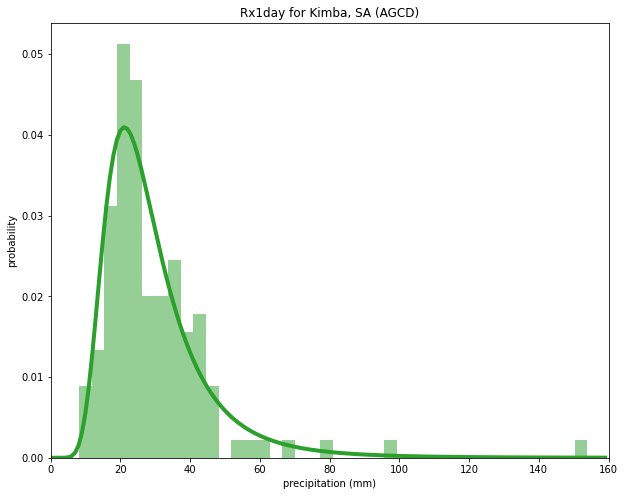

1454 year return period

99.93% percentile


In [27]:
gev_analysis(df_rx1day['pr'], rx1day_max)

Shape parameter: -0.10
Location parameter: 22.68
Scale parameter: 8.91


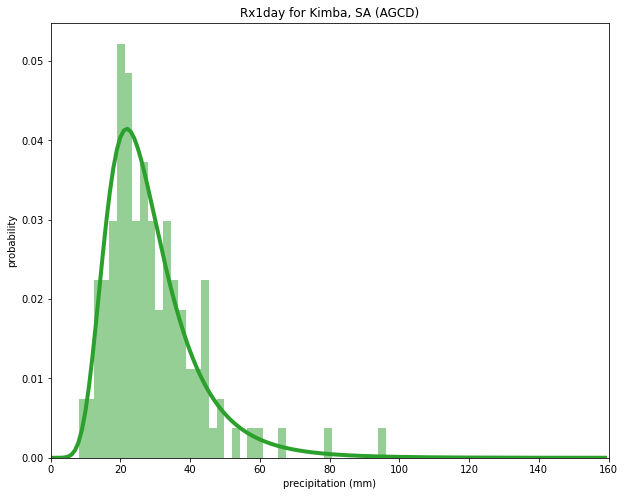

8929 year return period

99.99% percentile


In [28]:
gev_analysis(df_rx1day['pr'][:-1], rx1day_max)